In [1]:
! pip install replay-rec[torch] rs-datasets matplotlib --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.8/196.8 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.0/31.0 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.5/290.5 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

In [2]:
from datetime import datetime as dt
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader

from rs_datasets import MovieLens
from replay.splitters.time_splitter import TimeSplitter
from replay.preprocessing.filters import MinCountFilter, LowRatingFilter
from replay.metrics import NDCG, HitRate, Coverage, Experiment


## Нейросетевые подходы для рекомендаций: нейросетевая матричная факторизация

In [3]:
USER_COL = 'user_id'
ITEM_COL = 'item_id'
RATING_COL = 'rating'
TIMESTAMP = 'timestamp'
K=10
SEED=123

In [4]:
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

### Загрузка датасета Movielens 1m

In [5]:
ml = MovieLens('1m')
data = ml.ratings
u_features = ml.users
i_features = ml.items
ml.info()

INFO:rs_datasets:Downloading ml-1m from grouplens...
5.93MB [00:00, 7.03MB/s]                            


ratings


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968



users


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117



items


,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [6]:
data

,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


### Предобработка признаков

In [7]:
data = MinCountFilter(num_entries=20).transform(data)

In [8]:
data

,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [9]:
data = data[data[USER_COL].isin(u_features[USER_COL].unique())]
data = data[data[ITEM_COL].isin(i_features[ITEM_COL].unique())]

In [10]:
print(f'Количество уникальных пользователей: {data[USER_COL].nunique()}')
print(f'Количество уникальных фильмов: {data[ITEM_COL].nunique()}')

Количество уникальных пользователей: 6040
Количество уникальных фильмов: 3706


In [11]:
data[TIMESTAMP] = pd.to_datetime(data[TIMESTAMP], unit='s')

Переведем рейтинги в float формат для корректной работы моделей.

In [12]:
data[RATING_COL] = data[RATING_COL].astype(float)

## Разбиение данных

In [13]:
train, test = TimeSplitter(time_threshold=0.2,
                           drop_cold_users=True,
                           drop_cold_items=True,
                           query_column=USER_COL).split(data)

## Кодирование id пользователей и айтемов

In [14]:
u_features = u_features[u_features[USER_COL].isin(train[USER_COL].unique())]
i_features = i_features[i_features[ITEM_COL].isin(train[ITEM_COL].unique())]

In [15]:
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()
user_encoder.fit(train[USER_COL])
item_encoder.fit(train[ITEM_COL])

LabelEncoder()

In [16]:
train.loc[:, USER_COL] = user_encoder.transform(train[USER_COL])
train.loc[:, ITEM_COL] = item_encoder.transform(train[ITEM_COL])

test.loc[:, USER_COL] = user_encoder.transform(test[USER_COL])
test.loc[:, ITEM_COL] = item_encoder.transform(test[ITEM_COL])

u_features.loc[:, USER_COL]= user_encoder.transform(u_features[USER_COL])
i_features.loc[:, ITEM_COL]= item_encoder.transform(i_features[ITEM_COL])

<ipython-input-16-4c3ad6a80cac>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[5399 5399 5399 ...    0 1238 1238]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, USER_COL] = user_encoder.transform(train[USER_COL])
<ipython-input-16-4c3ad6a80cac>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 789 2162  573 ... 2082  745  817]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, ITEM_COL] = item_encoder.transform(train[ITEM_COL])
<ipython-input-16-4c3ad6a80cac>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1238 1238 1238 ... 4317 4317 4317]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  test.loc[:, USER_COL] = user_enco

## Фильтрация

Будем оценивать качество на фильмах с оценкой не менее 4 и на пользователях из train

In [17]:
test = LowRatingFilter(value=4).transform(test)

# Нейросетевая матричная факторизация
Будем использовать implicit-постановку и рассматривать фильмы, которые пользователь оценил, как положительный feedback.


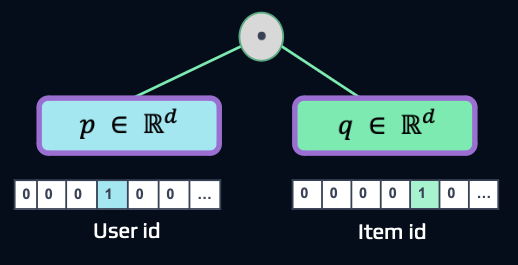

### Dataset

In [18]:
class TwoTowerTrain(Dataset):
    def __init__(self, data, num_negatives=10, i_features=None, u_features=None):
        self.data = data[[USER_COL, ITEM_COL]].to_numpy()
        self.num_negatives = num_negatives
        self.num_items = len(np.unique(self.data[:, 1]))
        self.i_features = i_features
        self.u_features = u_features

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        user_id, positive_item_id = self.data[idx, 0], self.data[idx, 1]
        items = torch.tensor(np.hstack([positive_item_id,
                                       np.random.randint(
                                           low=0,
                                           high=self.num_items,
                                           size=self.num_negatives)]),
                             dtype=torch.int32)

        labels = torch.zeros(self.num_negatives + 1, dtype=torch.float32)
        labels[0] = 1.

        return {'user_ids': torch.tensor([user_id], dtype=torch.int32),
                'item_ids': items,
                'labels': labels}

In [19]:
train_dataset = TwoTowerTrain(train)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=0)

In [20]:
batch = next(iter(train_loader))
batch

{'user_ids': tensor([[ 163],
         [3579],
         [2247],
         ...,
         [5362],
         [ 458],
         [4512]], dtype=torch.int32),
 'item_ids': tensor([[1036, 3582, 3437,  ..., 2154, 1147, 1593],
         [1806, 3286, 1761,  ..., 1568,  942, 2272],
         [2788,  111, 3481,  ..., 3280, 1092, 1847],
         ...,
         [2625, 3593,  879,  ...,  152, 2043,  747],
         [1823, 1817, 3338,  ..., 2000, 2648, 1063],
         [ 610, 3565, 1878,  ..., 1117, 3320, 3658]], dtype=torch.int32),
 'labels': tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]])}

### Модель

In [21]:
class SimpleTower(nn.Module):
    def __init__(self, num_embeddings, emb_dim):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings, emb_dim)

    def forward(self, ids, features=None):
        return self.emb(ids)

In [22]:
class BaseTwoHead(nn.Module):
    def __init__(self, emb_dim, user_config=None, item_config=None):
        super().__init__()
        self.emb_dim = emb_dim
        self.user_tower = SimpleTower(emb_dim=emb_dim, **user_config)
        self.item_tower = SimpleTower(emb_dim=emb_dim, **item_config)

    def forward(self, batch):
        item_emb = self.item_tower(batch["item_ids"])
        user_emb = self.user_tower(batch["user_ids"])
        dot_product = (user_emb * item_emb).sum(dim=-1)
        return dot_product

    def infer_users(self, batch):
        return self.user_tower(batch["user_ids"])

    def infer_items(self, batch):
        return self.item_tower(batch["item_ids"])

In [23]:
config = {
    'emb_dim' : 16,
}

user_config = {
    'num_embeddings' : train[USER_COL].max() + 1,
}

item_config = {
        'num_embeddings' : train[ITEM_COL].max() + 1,
}

model = BaseTwoHead(**config, user_config=user_config, item_config=item_config)

In [24]:
output = model(batch)
output.shape

torch.Size([1024, 11])

In [25]:
i_emb = model.infer_items(batch)
i_emb.shape

torch.Size([1024, 11, 16])

### Оптимизатор и функция потерь

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCEWithLogitsLoss()

### Цикл обучения

In [27]:
train_dataset = TwoTowerTrain(train)
train_loader = DataLoader(train_dataset, batch_size=4096, shuffle=True, num_workers=0)

In [28]:
test_dataset  = TwoTowerTrain(test)
test_loader = DataLoader(test_dataset, batch_size = 1024, shuffle=False, num_workers=0)

In [29]:
NUM_EPOCHS = 30

In [30]:
def loss_curve(train_loss_per_epoch, test_loss_per_epoch, epoch):
  clear_output()

  plt.figure(figsize=(10, 5))
  plt.title('Динамика train и test loss')
  plt.plot(train_loss_per_epoch, label='train')
  plt.plot(test_loss_per_epoch, label='test')
  plt.legend()
  plt.show()

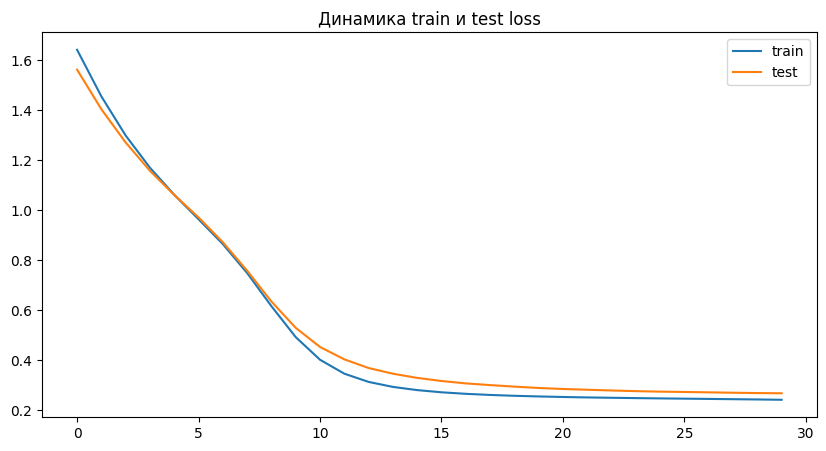

In [31]:
train_loss_per_epoch = []
test_loss_per_epoch = []
for epoch in tqdm(range(NUM_EPOCHS), desc='Epochs'):
    model.train()
    train_loss = 0.0
    for iteration, batch in enumerate(tqdm(train_loader, desc=f'Train iterations for epoch #{epoch}')):
        optimizer.zero_grad()
        preds = model(batch)
        loss = loss_fn(preds, batch['labels'])
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    model.eval()
    test_loss = 0
    for iteration, batch in enumerate(tqdm(test_loader, desc=f'Val iterations for epoch #{epoch}')):
        with torch.no_grad():
            preds = model(batch)
        loss = loss_fn(preds, batch['labels'])
        test_loss += loss.item()
    test_loss /= len(test_loader)
    test_loss_per_epoch.append(test_loss)
    train_loss_per_epoch.append(train_loss)

    loss_curve(train_loss_per_epoch, test_loss_per_epoch, epoch)

In [32]:
torch.save(model.state_dict(), f"/content/model_{NUM_EPOCHS}")

In [33]:
model = BaseTwoHead(**config, user_config=user_config, item_config=item_config)
model.load_state_dict(torch.load(f"/content/model_{NUM_EPOCHS}"))
model.eval()

<ipython-input-33-bed7c12f9716>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"/content/model_{NUM_EPOCHS}"))


BaseTwoHead(
  (user_tower): SimpleTower(
    (emb): Embedding(5400, 16)
  )
  (item_tower): SimpleTower(
    (emb): Embedding(3662, 16)
  )
)

## Получение рекомендаций

В нашем, самом простейшем случае, когда мы не используем промежуточные слои, а считаем скалярное произведение между выходами embedding-слоя, мы можем делать inference вообще не задействуя нейросеть, а считая скалярное произведение между весами эмбеддинг-слоя. В общем случае, когда мы используем признаки и/или башня состоит из нескольких слоев, можно один раз прогнать всех пользователей и айтемы через соответствующие башни, получить вектора и также считать скалярное произведение напрямую или с помощью ann.


### Inference моделью
Посмотрим на то, как выглядят output-ы модели. Это скоры выбранных айтемов (в нашем случае, 11 айтемов) для пользователя.

In [34]:
model.eval()
output = model(batch)
output.shape

torch.Size([953, 11])

In [35]:
# логиты для первого пользователя в батче
output[0]

tensor([-2.5334, -1.1955, -4.7357, -3.8012,  0.3710, -2.3591, -3.9539, -6.0750,
        -1.7040, -4.6693, -3.5852], grad_fn=<SelectBackward0>)

In [36]:
# релевантности для первого пользователя в батче
nn.Sigmoid()(output[0])

tensor([0.0735, 0.2323, 0.0087, 0.0219, 0.5917, 0.0863, 0.0188, 0.0023, 0.1539,
        0.0093, 0.0270], grad_fn=<SigmoidBackward0>)

### Скалярное произведение векторов пользователя и продукта
Получение векторов пользователя и продукта из соответствующих башен:

In [37]:
u_emb = model.infer_users(batch)
u_emb.shape

torch.Size([953, 1, 16])

In [38]:
i_emb = model.infer_items(batch)
i_emb.shape

torch.Size([953, 11, 16])

Скоры, полученные двумя способами совпадают, отлично:

In [39]:
(output[0] != (u_emb * i_emb).sum(dim=-1)[0]).sum()

tensor(0)

### Получение рекомендаций для тестовых пользователей

Для простоты пайплайна не будем делать фильтрацию просмотренных продуктов.

In [40]:
test_users = test[[USER_COL]].drop_duplicates().reset_index(drop=True)
test_users.head(2)

,user_id
0,1238
1,0


In [41]:
user_embed = model.user_tower.emb.weight.detach().cpu().numpy()
item_embed = model.item_tower.emb.weight.detach().cpu().numpy()
user_embed.shape, item_embed.shape

((5400, 16), (3662, 16))

In [42]:
scores = user_embed[test_users[USER_COL].values]@item_embed.T
ids = np.argpartition(scores, -K)[:, -K:]
scores = np.take_along_axis(scores, ids, axis=1)

In [43]:
def prepare_recs(test_users, rec_item_ids, rec_relevances):
    predict = test_users.copy()
    predict[ITEM_COL] = rec_item_ids.tolist()
    predict['rating'] = rec_relevances.tolist()
    predict = predict.explode(column=[ITEM_COL, 'rating']).reset_index(drop=True)
    predict[ITEM_COL] = predict[ITEM_COL].astype(int)
    predict['rating'] = predict['rating'].astype("double")
    return predict

In [44]:
inner_product_predict = prepare_recs(test_users,
                           rec_item_ids=ids,
                           rec_relevances=scores)

### Подсчет метрик

In [45]:
metrics = Experiment(
    [NDCG(K), HitRate(K), Coverage(K)],
    test,
    train,
    query_column=USER_COL, item_column=ITEM_COL,
)

In [46]:
metrics.add_result("MF", inner_product_predict)
metrics.results

,NDCG@10,HitRate@10,Coverage@10
MF,0.082706,0.384135,0.114691


Итак, мы получили простую модель, которая представляет собой аналог матричной факторизации на torch. Чтобы улучшить наш прототип, можно начать со следующих идей:
- добавление признаков и дополнительных слоев, выбор способа кодирования признаков (полноценная двухбашенная модель)
- подбор количества негативных примеров и выбор наилучшей функции потерь (BCE, CE, TripletMarginLoss, etc.)
- динамический lr + early stopping